In [1]:
from google.colab import drive
drive.mount('/content/drive')

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

datadir = "/content/drive/My Drive/CS543"

Mounted at /content/drive


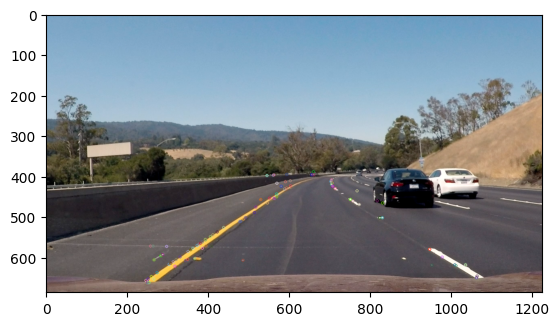

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取图像
# 把图片导到这个位置即可
image = cv2.imread('/content/drive/MyDrive/CS543/challenge-area-1.png')

# 转成HSV
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# yellow and white hsv range
yellow_low = np.array([15, 100, 100])
yellow_high = np.array([35, 255, 255])
white_low = np.array([0, 0, 0])
white_high = np.array([360, 20, 255])

mask_yellow = cv2.inRange(image_hsv, yellow_low, yellow_high)
mask_white = cv2.inRange(image_hsv, white_low, white_high)
combined_mask = cv2.bitwise_or(mask_yellow, mask_white)

# Sift
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(image, mask=combined_mask)

# 只看半张图
half_keypoints = []
for i in range(len(keypoints)):
  if keypoints[i].pt[1]>image.shape[0]/2:
    half_keypoints.append(keypoints[i])
keypoints = half_keypoints

# 分别处理左右两侧的keypoints
key_left = []
key_right = []


# 坐标计算
for i in keypoints:
  coor = i.pt
  if(coor[0]<=image.shape[0]):
    if coor[0]/(image.shape[1]/2) + coor[1]/(image.shape[0]/2)>=2:
      key_left.append(i)
  else:
    if -(coor[0]-image.shape[1]/2)/(image.shape[1]/2) + coor[1]/(image.shape[0]/2)>=1:
      key_right.append(i)

# keypoints结果
keypoint_image = cv2.drawKeypoints(image, key_left+key_right, None)

# 将BGR图像转换为RGB以便在matplotlib中显示
keypoint_image_rgb = cv2.cvtColor(keypoint_image, cv2.COLOR_BGR2RGB)

# 使用matplotlib显示图像
plt.figure()
plt.imshow(keypoint_image_rgb)
plt.show()


#转换成array
points_left = []
points_right = []
for i in range(len(key_left)):
  points_left.append(key_left[i].pt)
for i in range(len(key_right)):
  points_right.append(key_right[i].pt)
points_left = np.array(points_left)
points_right = np.array(points_right)
# keypoints同样转换
keypoints_array = np.zeros((len(keypoints), 2))
for i in range(len(keypoints)):
  keypoints_array[i] = keypoints[i].pt
keypoints = keypoints_array
# 只保留left 和 right的keypoint
key_valid = key_left + key_right
key_valid_array = np.zeros((len(key_valid), 2))
for i in range(len(key_valid)):
  key_valid_array[i] = key_valid[i].pt
key_valid = key_valid_array

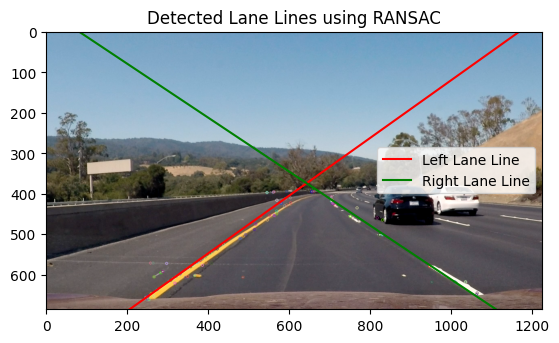

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor

# handle left side
model_left = RANSACRegressor()
model_left.fit(points_left[:, 1].reshape(-1, 1), points_left[:, 0])

# handle right side
model_right = RANSACRegressor()
model_right.fit(points_right[:, 1].reshape(-1, 1), points_right[:, 0])

# lines
left_line_x = np.linspace(0, image.shape[1], 100)
left_line_y = model_left.predict(left_line_x.reshape(-1, 1))
right_line_x = np.linspace(0, image.shape[1], 100)
right_line_y = model_right.predict(right_line_x.reshape(-1, 1))

plt.figure()
# uncomment如果需要特别加深keypoint结果
# plt.scatter(key_valid[:, 0], key_valid[:, 1], c='blue', label='Feature Points')
plt.plot(left_line_y, left_line_x, color='red', label='Left Lane Line')
plt.plot(right_line_y, right_line_x, color='green', label='Right Lane Line')
plt.imshow(keypoint_image_rgb)

plt.legend()
plt.title('Detected Lane Lines using RANSAC')
plt.show()

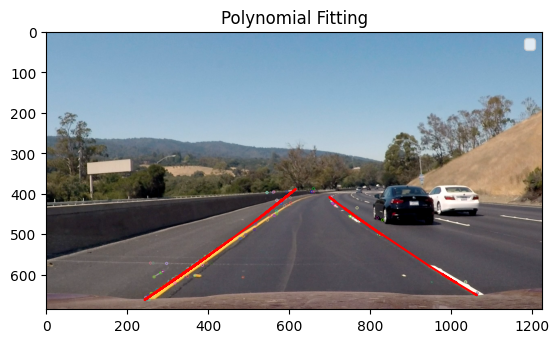

In [4]:
import numpy as np
import matplotlib.pyplot as plt


# Fit a polynomial of degree 2 (quadratic)
degree = 2
left_coefficients = np.polyfit(points_left[:, 1], points_left[:, 0], degree)
right_coefficients = np.polyfit(points_right[:, 1], points_right[:, 0], degree)

# Create a polynomial function from the coefficients
left_polynomial = np.poly1d(left_coefficients)
right_polynomial = np.poly1d(right_coefficients)

# Generate y values using the polynomial function
left_y_fit = left_polynomial(points_left[:, 1])
right_y_fit = right_polynomial(points_right[:, 1])

# Plot the original data points and the fitted polynomial curve
plt.plot(left_y_fit,points_left[:, 1], color='red')
plt.plot(right_y_fit, points_right[:, 1], color='red')
plt.imshow(keypoint_image_rgb)
plt.title('Polynomial Fitting')
plt.legend()
plt.show()